In [5]:
from google.colab import files
uploaded = files.upload()

Saving UCI_Adult_Income.csv to UCI_Adult_Income.csv


In [7]:
# --- Step 1: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

import shap
shap.initjs()   # for interactive visualizations

In [8]:
# --- Step 2: Load Dataset ---

df = pd.read_csv("UCI_Adult_Income.csv")

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (48842, 15)
   age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18        NaN  103497  Some-college             10       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                NaN    Own-child  White  Female             0             0   

   hours-per-week nativ

In [9]:
# --- Step 3: Clean Data ---
# Strip whitespace in column names and string values
df.columns = df.columns.str.strip()

# df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()


# Drop rows with missing values represented by '?'
df = df[(df != '?').all(axis=1)]
print("After cleaning:", df.shape)


After cleaning: (48842, 15)


In [10]:
# --- Step 4: Encode categorical columns ---
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print(df.head())


   age  workclass  fnlwgt  education  education-num  marital-status  \
0   25          3  226802          1              7               4   
1   38          3   89814         11              9               2   
2   28          1  336951          7             12               2   
3   44          3  160323         15             10               2   
4   18          8  103497         15             10               4   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           6             3     2    1             0             0   
1           4             0     4    1             0             0   
2          10             0     4    1             0             0   
3           6             0     2    1          7688             0   
4          14             3     4    0             0             0   

   hours-per-week  native-country  class  
0              40              38      0  
1              50              38      0  
2              40      

In [11]:
# --- Step 5: Split into train/test with sensitive variables ---
X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# --- Step 6: Train Model with sensitive variables---
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8577083191155395

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     11233
           1       0.78      0.55      0.64      3420

    accuracy                           0.86     14653
   macro avg       0.83      0.75      0.78     14653
weighted avg       0.85      0.86      0.85     14653



Original 3D SHAP array shape: (14653, 14, 2)
Sliced 2D SHAP array for Class 1 shape: (14653, 14)
X_test shape: (14653, 14)
Displaying SHAP Beeswarm Plot for Class 1...


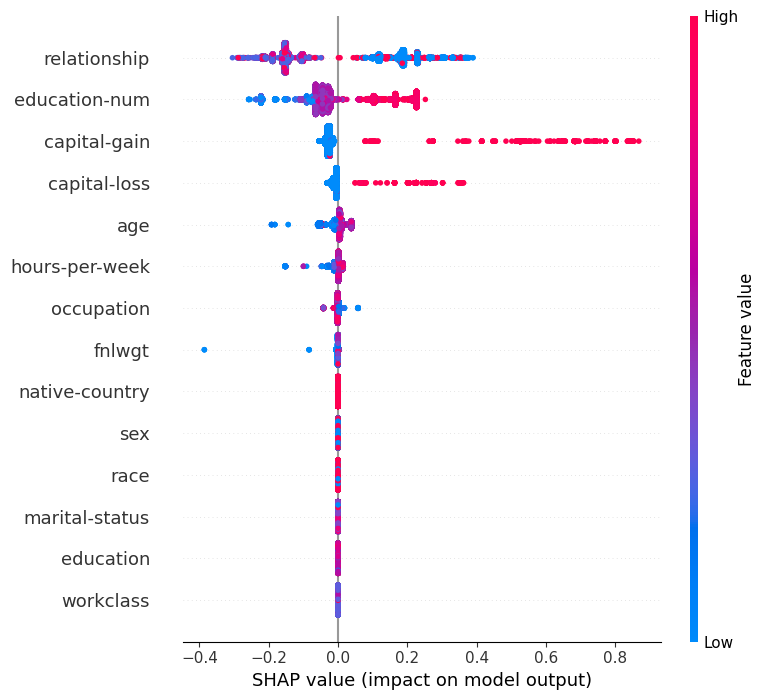

Displaying SHAP Bar Plot for Class 1...


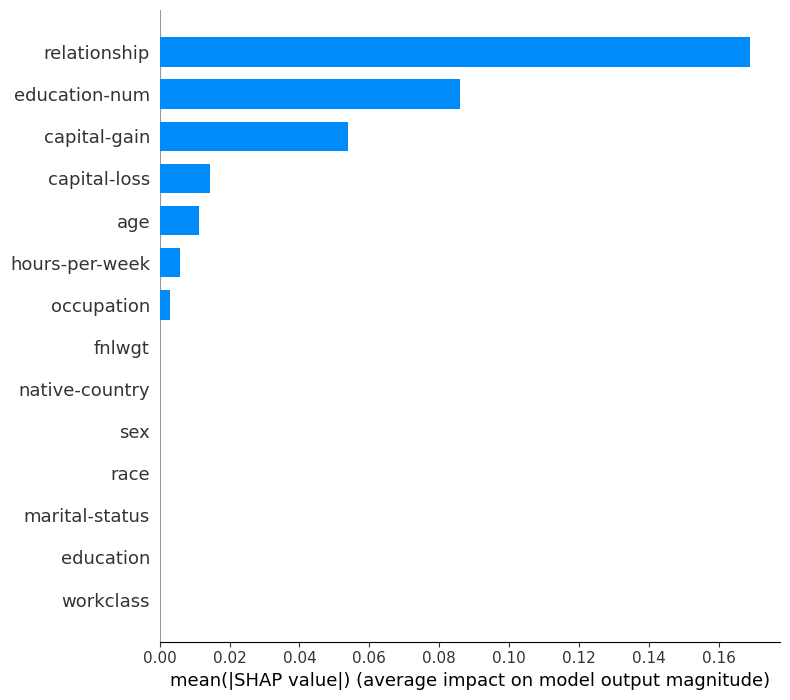

In [13]:
# %%
# --- Step 7: SHAP Explainability (Corrected) ---

# 1. Use TreeExplainer explicitly
explainer = shap.TreeExplainer(model)

# 2. Get the raw SHAP values.
# This will be a 3D array: (n_samples, n_features, n_classes)
shap_values = explainer.shap_values(X_test)

# --- THIS IS THE FIX ---
# We need to get the values for Class 1 (">50K")
# We slice the 3D array to get a 2D array: (n_samples, n_features)
shap_values_class_1 = shap_values[:, :, 1]
# --- END OF FIX ---

# 3. Print shapes to confirm
print(f"Original 3D SHAP array shape: {shap_values.shape}")
print(f"Sliced 2D SHAP array for Class 1 shape: {shap_values_class_1.shape}")
print(f"X_test shape: {X_test.shape}")


# 4. Create the summary plot (beeswarm) for Class 1
# This will now work, as (14653, 14) matches (14653, 14)
print("Displaying SHAP Beeswarm Plot for Class 1...")
shap.summary_plot(shap_values_class_1, X_test)


# 5. Create the bar plot for Class 1
print("Displaying SHAP Bar Plot for Class 1...")
shap.summary_plot(shap_values_class_1, X_test, plot_type="bar")